In [1]:
import sys
print(sys.executable)


C:\Users\matthew.fleischman\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
from pylab import *
import matplotlib.pyplot as plt
import os
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pandas as pd
import numpy as np

Graphviz is not installed. 
  Please install this program in order to visualize graphical models in pyagrum. 
  See https://graphviz.org/download/


Define string to integer method for later use.

In [3]:
def string_int_lst(string_lst):

    # Check for unique entries
    unique_lst = []
    for string in string_lst:
        if string not in unique_lst:
            unique_lst.append(string)
    
    # Create a dictionary mapping each string to an integer starting from 0
    return {string: index for index, string in enumerate(unique_lst)}

Define method to get CPT values. For later use.

In [4]:
def get_CPT(var, relationships, prob_tables):
    for relation in relationships:
        if var == relation[0]:
            condition_str = ", ".join(relation[1:])
            CPT = prob_tables[f"{relation[0]}|{condition_str}"]
            CPT_return = []
            if relation[1] == "None":
                CPT_return = list(CPT.index)
            else:
                CPT_return = list(CPT.columns)
    return CPT_return

Gather data from CSV.

In [5]:
fields = ["Accident_Severity", "Number_of_Vehicles",
          "Number_of_Casualties", "Road_Type", "Speed_limit", "Light_Conditions", 
          "Weather_Conditions", "Road_Surface_Conditions", "Urban_or_Rural_Area"]
relationships = [["Urban_or_Rural_Area", "None"],
                ["Weather_Conditions", "None"],
                ["Light_Conditions", "None"],
                ["Road_Type", "Urban_or_Rural_Area"],
                ["Number_of_Vehicles", "Road_Type"],
                ["Speed_limit", "Road_Type"],
                ["Road_Surface_Conditions", "Weather_Conditions"],
                ["Number_of_Casualties", "Number_of_Vehicles"],
                ["Accident_Severity", "Speed_limit", "Road_Surface_Conditions", "Light_Conditions"]]

prob_tables = {}    

# Read in data
df = pd.read_csv('accidents_2012_to_2014.csv', usecols=fields)
df['Number_of_Casualties'] = df['Number_of_Casualties'].clip(upper=3)
df['Number_of_Vehicles'] = df['Number_of_Vehicles'].clip(upper=7)

for relation in relationships:

    if relation[1] != "None":
        # Create a contingency table
        conditions = [df[relation[i]] for i in range(1, len(relation))]
        contingency_table = pd.crosstab(columns=df[relation[0]], index=conditions)

        # Calculate conditional probability
        row_totals = contingency_table.sum(axis=1)
        CPT = contingency_table.div(row_totals, axis=0)

        # Assign to dictionary
        cond_str = ", ".join(relation[1:])
        prob_tables[f"{relation[0]}|{cond_str}"] = CPT

    else:
        # Create a simple probability table (not conditional)
        value_counts = df[relation[0]].value_counts()
        
        # Calculate the probability table by dividing by the total count
        PT = value_counts / len(df)
        prob_tables[f"{relation[0]}|None"] = PT

Create Bayesian Network.

In [6]:
bn=gum.InfluenceDiagram()

for relation in relationships:
    condition_str = ", ".join(relation[1:])
    CPT = prob_tables[f"{relation[0]}|{condition_str}"]

    # Add nodes
    if relation[1] == "None":
        bn.addChanceNode(gum.LabelizedVariable(relation[0], "", CPT.shape[0]))
    else:
        bn.addChanceNode(gum.LabelizedVariable(relation[0], "", len(CPT.columns)))

    # Add arks    
    if relation[1] != "None":
        for i in range(1,len(relation)):
            bn.addArc(relation[i], relation[0])

    # Add PTs (Non-conditional probabilities)
    if relation[1] == "None":
        bn.cpt(relation[0]).fillWith(CPT.values)

    # Add CPTs 
    else:
        # One condition
        if len(relation) == 2:
            for k in range(len(CPT.index)):
                bn.cpt(relation[0])[{relation[1] : k}] = CPT.values[k].tolist()
        # Two conditions
        elif len(relation) == 3:
            dicts = [string_int_lst([index[i] for index in CPT.index]) for i in range(2)] #string to integer associations
            for l, index in enumerate(CPT.index):
                bn.cpt(relation[0])[{relation[i + 1]: dicts[i].get(index[i]) for i in range(2)}] = CPT.values[l].tolist() #assign probability to each condition perputation
        # Three conditions
        elif len(relation) == 4:
            dicts = [string_int_lst([index[i] for index in CPT.index]) for i in range(3)]
            for l, index in enumerate(CPT.index):
                bn.cpt(relation[0])[{relation[i + 1]: dicts[i].get(index[i]) for i in range(3)}] = CPT.values[l].tolist()

Add Decision and Utility Nodes.

In [7]:
# Add nodes
bn.addDecisionNode(gum.LabelizedVariable('Level_of_Response', 'Decision', 3))
bn.addUtilityNode(gum.LabelizedVariable('Minimized_Injury', 'Utility', 1))

# Add arcs
bn.addArc("Number_of_Vehicles", "Level_of_Response")
bn.addArc("Speed_limit", "Level_of_Response")
bn.addArc("Road_Surface_Conditions", "Level_of_Response")
bn.addArc("Light_Conditions", "Level_of_Response")
bn.addArc("Number_of_Casualties", "Minimized_Injury")
bn.addArc("Accident_Severity", "Minimized_Injury")
bn.addArc("Level_of_Response", "Minimized_Injury")

# Utility Table
utility_table = [
    [1, 1, 1, 5],
    [1, 1, 2, 3],
    [1, 1, 3, 1],
    [1, 2, 1, 4],
    [1, 2, 2, 4],
    [1, 2, 3, 2],
    [1, 3, 1, 3],
    [1, 3, 2, 4],
    [1, 3, 3, 3],
    [2, 1, 1, 4],
    [2, 1, 2, 4],
    [2, 1, 3, 2],
    [2, 2, 1, 3],
    [2, 2, 2, 5],
    [2, 2, 3, 3],
    [2, 3, 1, 2],
    [2, 3, 2, 4],
    [2, 3, 3, 4],
    [3, 1, 1, 3],
    [3, 1, 2, 5],
    [3, 1, 3, 3],
    [3, 2, 1, 2],
    [3, 2, 2, 4],
    [3, 2, 3, 4],
    [3, 3, 1, 1],
    [3, 3, 2, 3],
    [3, 3, 3, 5]
]
# Add the utility table to the Network
for row in utility_table:
    utility_lst = [0,0,0,0,0]
    for i in range(5):
        if (i+1) == row[3]:
            utility_lst[i] = 1 
    bn.utility('Minimized_Injury')[{'Accident_Severity': row[0]-1, 'Number_of_Casualties': row[1]-1, 'Level_of_Response': row[2]-1}] = row[3] #-1 for indexing reasons

bn.utility('Minimized_Injury')

(pyagrum.Tensor@0000021B64405500) 
                    ||  Minimiz|
Number|Accide|Level_||0        |
------|------|------||---------|
0     |0     |0     || 5.0000  |
1     |0     |0     || 4.0000  |
2     |0     |0     || 3.0000  |
0     |1     |0     || 4.0000  |
1     |1     |0     || 3.0000  |
2     |1     |0     || 2.0000  |
[...15 more line(s) ...]
0     |1     |2     || 2.0000  |
1     |1     |2     || 3.0000  |
2     |1     |2     || 4.0000  |
0     |2     |2     || 3.0000  |
1     |2     |2     || 4.0000  |
2     |2     |2     || 5.0000  |

Evidence.

In [8]:
# Get possible values for evidence variable
evidence_var = "Road_Surface_Conditions"
values_lst = get_CPT(evidence_var, relationships, prob_tables)
evidence_dict = string_int_lst(values_lst)
print(f"Possible evidence values for {evidence_var}:")
print(list(evidence_dict.keys()))

Possible evidence values for Road_Surface_Conditions:
['Dry', 'Flood (Over 3cm of water)', 'Frost/Ice', 'Snow', 'Wet/Damp']


Make Inferences.

In [9]:
ie=gum.ShaferShenoyLIMIDInference(bn)
ie.setEvidence({evidence_var:evidence_dict['Frost/Ice']}) # Set variable here
ie.makeInference()

Get probailities.

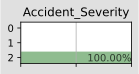

Integer Value correspondance:
{1: 0, 2: 1, 3: 2}


In [10]:
target_var = "Accident_Severity"
gnb.showProba(ie.posterior(target_var))
values_lst = get_CPT(target_var, relationships, prob_tables)
print(f"Integer Value correspondance:\n{string_int_lst(values_lst)}")

Make Optimal Decisions

In [11]:
optimal_decision = ie.optimalDecision("Level_of_Response")
optimal_decision

(pyagrum.Tensor@0000021B64402D40) 
                           ||  Level_of_Response          |
Number|Speed_|Road_S|Light_||0        |1        |2        |
------|------|------|------||---------|---------|---------|
0     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
1     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
2     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
3     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
4     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
5     |0     |0     |0     || 1.0000  | 0.0000  | 0.0000  |
[...1038 more line(s) ...]
1     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |
2     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |
3     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |
4     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |
5     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |
6     |5     |4     |4     || 1.0000  | 0.0000  | 0.0000  |